In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

In [15]:
colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']
plt.style.use('seaborn-notebook')

In [16]:
import urllib.request

filepath = "../dataset/"
url = "https://tvml.github.io/ml1920/dataset/"

def get_file(filename,local):
    if local:
        return filepath+filename
    else:
        urllib.request.urlretrieve (url+filename, filename)
        return filename

In [17]:
f = lambda d: int(d[0:4])

In [18]:
tfp = pd.read_csv(get_file('RTFPNAITA632NRUG.csv', True), header=0, names=['date','it'])
tfp['de'] = pd.read_csv(get_file('RTFPNADEA632NRUG.csv', True), header=0).iloc[:,1]
tfp['fr'] = pd.read_csv(get_file('RTFPNAFRA632NRUG.csv', True), header=0).iloc[:,1]
tfp['es'] = pd.read_csv(get_file('RTFPNAESA632NRUG.csv', True), header=0).iloc[:,1]
tfp['gb'] = pd.read_csv(get_file('RTFPNAGBA632NRUG.csv', True), header=0).iloc[:,1]
tfp = tfp.set_index(tfp.date)
tfp = tfp.drop(['date'], axis=1)

In [19]:
years = tfp.index.map(f)
tfp = tfp.set_index(years)

In [20]:
tfp['it'] = tfp['it']/tfp['it'].iloc[0]
tfp['de'] = tfp['de']/tfp['de'].iloc[0]
tfp['fr'] = tfp['fr']/tfp['fr'].iloc[0]
tfp['es'] = tfp['es']/tfp['es'].iloc[0]
tfp['gb'] = tfp['gb']/tfp['gb'].iloc[0]

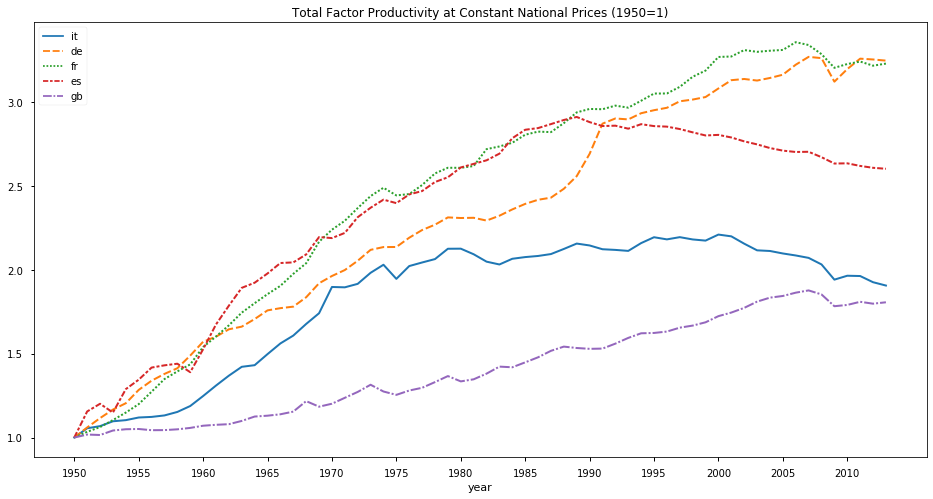

In [21]:
fig= plt.figure(figsize=(16,8))
ax = sns.lineplot(data=tfp, linewidth=2)
#ax.set(xlim=(0,tfp.shape[0]-1))
ax.set(xticks=(years[np.arange(0,years.shape[0],5)]))
ax.set(xticklabels=(years[np.arange(0,years.shape[0],5)]))
ax.set(xlabel=('year'))
ax.set(title='Total Factor Productivity at Constant National Prices (1950=1)')
plt.show()

In [28]:
prod = tfp.it.pct_change()
prod.iloc[0] = 0

In [29]:
prod

date
1950    0.000000
1951    0.055239
1952    0.012018
1953    0.027098
1954    0.006140
          ...   
2009   -0.044648
2010    0.011987
2011   -0.000891
2012   -0.018750
2013   -0.010334
Name: it, Length: 64, dtype: float64

In [30]:
w = 0
if w==0:
    data = prod
else:
    data = prod.rolling(w).mean()[w:]

In [38]:
data.index

Int64Index([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
            1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
            1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
            1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
            1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
            2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013],
           dtype='int64', name='date')

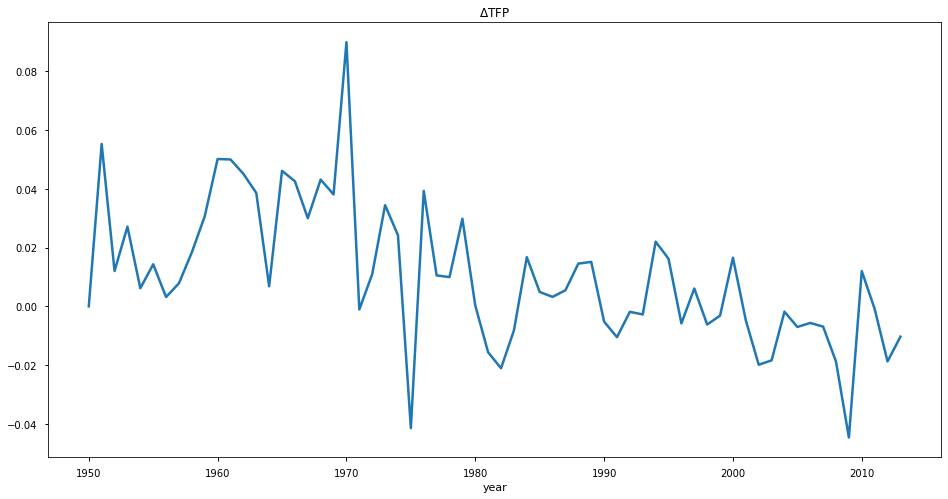

In [41]:
fig = plt.figure(figsize=(16,8))
plt.plot(data.index, data, linewidth=2.5)
plt.xlabel('year')
plt.title('$\Delta$TFP')
plt.show()

In [42]:
with pm.Model() as prod_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=int(years[0]), upper=int(years[-1]))

    early_mean = pm.Uniform('early_mean', lower=prod.min(), upper=prod.max())
    early_std = pm.Exponential('early_std', 1)
    early_rate = pm.Normal('early_rate', early_mean, early_std)
    
    late_mean = pm.Uniform('late_mean', lower=prod.min(), upper=prod.max())
    late_std = pm.Exponential('late_std', 1)
    late_rate = pm.Normal('late_rate', late_mean, late_std)

    mean = pm.math.switch(switchpoint >= years, early_mean, late_mean)
    std = pm.math.switch(switchpoint >= years, early_std, late_std)

    productivity = pm.Normal('prod', mean, std, observed=prod)

In [43]:
with prod_model:
    trace = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, late_std, late_mean, early_rate, early_std, early_mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:35<00:00, 597.21draws/s]
The number of effective samples is smaller than 10% for some parameters.


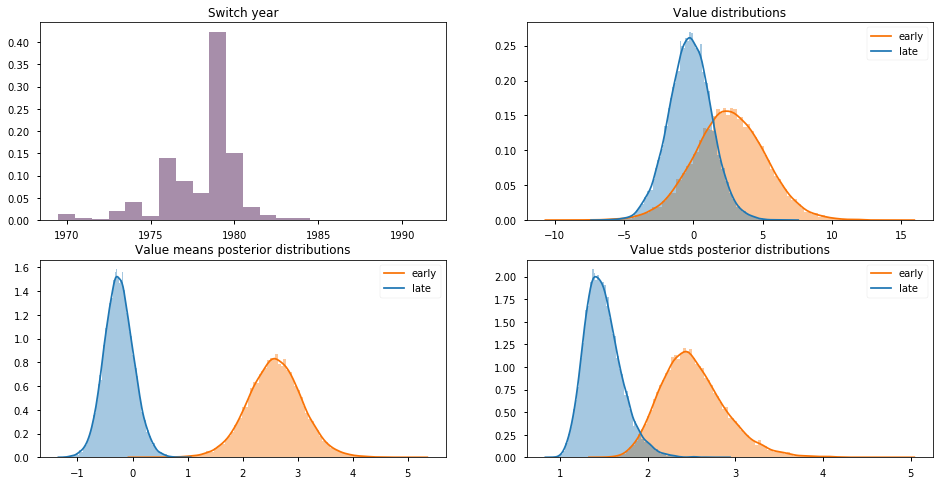

In [46]:
fig = plt.figure(figsize=(16,8))
plt.subplot(221)
plt.hist(trace['switchpoint'], trace['switchpoint'].max()-trace['switchpoint'].min(), density=True, color="xkcd:dusty purple", alpha=0.7, align='left')
plt.title('Switch year')
plt.subplot(222)
sns.distplot(trace['early_rate']*100, bins=100, hist=True,  color="xkcd:orange", kde_kws={'label':'early'})
sns.distplot(trace['late_rate']*100, bins=100, hist=True,  kde_kws={'label':'late'})
plt.legend()
plt.title('Value distributions')
plt.subplot(223)
sns.distplot(trace['early_mean']*100, bins=100, hist=True, color="xkcd:orange", kde_kws={'label':'early'})
sns.distplot(trace['late_mean']*100, bins=100, hist=True, kde_kws={'label':'late'})
plt.title('Value means posterior distributions')
plt.subplot(224)
sns.distplot(trace['early_std']*100, bins=100, hist=True, color="xkcd:orange", kde_kws={'label':'early'})
sns.distplot(trace['late_std']*100, bins=100, hist=True, kde_kws={'label':'late'})
plt.legend()
plt.title('Value stds posterior distributions')
plt.show()

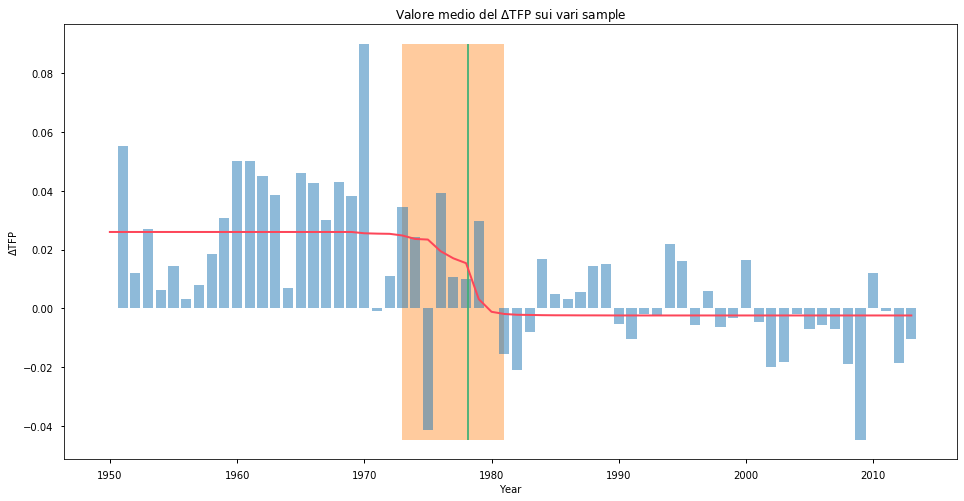

In [69]:
plt.figure(figsize=(16, 8))
plt.bar(years, prod, alpha=.5)
plt.ylabel("$\Delta$TFP", fontsize=10)
plt.xlabel("Year", fontsize=10)

plt.vlines(trace['switchpoint'].mean(), prod.min(), prod.max(), color="xkcd:dark seafoam green")
average_prod = np.zeros_like(prod, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_prod[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[prod.min(), prod.max()], x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.4)
plt.plot(years, average_prod,  lw=2, color="xkcd:watermelon", label='average_prod')
plt.title('Valore medio del $\Delta$TFP sui vari sample')
plt.show()